<a href="https://colab.research.google.com/github/yilin10/MusicalGenreClassification/blob/master/Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CMLS - Assignment 1: Music Genre Classification


## Introduction

This is a brief report for Computer Music: Language and Systesms in Politecnico di Milano, Group 5 Assignment 1. 

It is written as IPython Notebook using Google Colaboratory.

The full report version is available on OverLeaf [link](https://www.overleaf.com/1494782774kwgkjvfgddzq).



## Import Libraries

Import of **Libraries** we needed.

In [0]:
# import python libraries
import librosa
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import IPython.display as ipd
import scipy as sp
from tqdm.notebook import tqdm
from time import sleep

# import classification and evaluation libraries
import sklearn.svm
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn import datasets
import sklearn.neighbors as neighbors
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import sklearn.preprocessing as preprocessing

Use the personal **Kaggle Api token** to enable download from Kaggle.

In [0]:
from google.colab import files
files.upload() # Choose kaggle.json (your personal Kaggle API token)

! rm -r ~/.kaggle
! mkdir ~/.kaggle
! mv kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json # Change the permissions of the file.

Saving kaggle.json to kaggle.json


Download of the dataset from Kaggle, and unzip the dataset



In [0]:
! pip install -q kaggle
! mkdir ~/dataset
! kaggle datasets download -d carlthome/gtzan-genre-collection
! unzip -q gtzan-genre-collection.zip -d ~/dataset

 99% 1.13G/1.14G [00:20<00:00, 55.9MB/s]
100% 1.14G/1.14G [00:20<00:00, 60.8MB/s]


## Observation and Retrieving Annotations


The original Dataset we are using is from [Kaggle](https://www.kaggle.com/carlthome/gtzan-genre-collection) and provided by [GTZAN](http://marsyas.info/downloads/datasets.html), which is the most widely used free database in music genre recognition field.

We need to classify the four Music Genre categories **Blues, Metal, Hip-Hop, Reggae**.


In the description part, we can see the brief infomation on this data set.

```
The dataset consists of 1000 audio tracks each 30 seconds long. 

It contains 10 genres, each represented by 100 tracks. 

The tracks are all 22050 Hz monophonic 16-bit audio files in .au format.
```




In [18]:
# save data in genre.csv
genre_analysis_list = ["blues","metal","hiphop","reggae"]  
genre_list = []  
path_list = []
train_path = "../root/dataset/genres/"

for each in tqdm(genre_analysis_list):
    train_test_folder = train_path + format(each)
    train_catg_files = [f for f in os.listdir(train_test_folder) if f.endswith('.au')]
    for index, each_file in enumerate(train_catg_files):
        each_file_path = os.path.join(train_test_folder, each_file)
        genre_list.append(each)
        path_list.append(each_file_path)
genre_data = pd.DataFrame(list(zip(genre_list,path_list)),columns = ['Genre','Path'])
genre_data.to_csv('./genres.csv',sep = '\t', index = False)

Check the annotation retrived.

In [19]:
genre_data.describe # get pd.DataFrame

<bound method NDFrame.describe of       Genre                                           Path
0     blues    ../root/dataset/genres/blues/blues.00013.au
1     blues    ../root/dataset/genres/blues/blues.00041.au
2     blues    ../root/dataset/genres/blues/blues.00071.au
3     blues    ../root/dataset/genres/blues/blues.00033.au
4     blues    ../root/dataset/genres/blues/blues.00089.au
..      ...                                            ...
395  reggae  ../root/dataset/genres/reggae/reggae.00080.au
396  reggae  ../root/dataset/genres/reggae/reggae.00067.au
397  reggae  ../root/dataset/genres/reggae/reggae.00043.au
398  reggae  ../root/dataset/genres/reggae/reggae.00024.au
399  reggae  ../root/dataset/genres/reggae/reggae.00092.au

[400 rows x 2 columns]>

## Preprocessing

Go through the files and check .au basic info, we can pick random samples to check according to statistic principle.
- sample rate
- duration in seconds
- static tempo

By executing the following code we can get the same information on this dataset which confirms with the provided info.

In [20]:
import warnings 
# ignore dw warning from librosa.beat
warnings.filterwarnings("ignore", category=DeprecationWarning) 
# get 20% of check_sample from original dataset
check_sample = genre_data['Path'].sample(frac = 0.2, replace = False,
                                         random_state = None, axis = 0 )
sr_list = []
dur_list = []
tempo_list = []
for p in tqdm(check_sample):
    #read audio file 
    y, sr = librosa.load(p) 
    #1. get sample rate
    sr_list.append(sr)
    #2. get duration
    dur = round(librosa.get_duration(y=y, sr=sr))
    dur_list.append(dur)
    #3. static tempo
    onset_env = librosa.onset.onset_strength(y, sr=sr)
    tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)
    tempo_list.append(round(tempo[0]))
print("sample rate: ", sr_list) # sample rate = 22050
print("duration in seconds: ", dur_list)
print("static tempo: ", tempo_list)


sample rate:  [22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050]
duration in seconds:  [30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 31, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 31, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 31, 30, 30]
static tempo:  [136.0, 112.0, 92.0, 108.0, 108.0, 152.0, 152.0, 117.0, 92.0, 129.

In [21]:
print("--- Statistics for sample data in static tempo ---")
print("Mean", np.mean(tempo_list))
print("Min",np.min(tempo_list))
print("Max",np.min(tempo_list))
print("Median", np.median(tempo_list))
print("Std", np.std(tempo_list))

--- Statistics for sample data in static tempo ---
Mean 120.575
Min 89.0
Max 89.0
Median 117.0
Std 20.73208564037878


Here we can print to see the statistic info in tempo as a test. We can see in rhythmic part the standard diviation is quiet obvious, which makes it possible to distinguish different different genres.

**Check the quality of the Original dataset**

- if it is balanced
- if it has repetition
- if it is able to describe differnet genre

According to a research result we found [[1]](https://arxiv.org/abs/1306.1461), the audio pieces from GTZAN is not perfect, it does have repetitions, and dislabelling error.

In the research result we find from the paper, they checked each audio piece both using fingerprinting of the audio and also human ears.

There are different kinds of repetition and mislabelling in the GTZAN dataset(as recording repetition, artist repetiton and version repetition and others).

1. **Recording repetition**: 0 error in blues, 6 in hiphop, 0 in metal, 3 in reggae
2. **Artist unbalanced**: all blues audio come from only 9 artists; 34 % of the Reggae pieces come from artist Bob Marley(no.00-27 and no.54-60)
3. **Version repetition**: 0 in blues, 2 in hiphop, 3 in Metal, 2 in Reggae; eg. Metal 33 is “Enter Sandman” by Metallica, and Metal 74 is a parody
4. **Mislabelling**: there are some contentious or conscpicious labelled piece; eg. In Metal Genre, Queen's “Tie Your Mother Down” (no.58), “Tear it up” (no.59), “We Will Rock You” (no.60) might be labelled as Rock instead; In all, there are 0 error in blues, 4 in Hiphop, 13 in Metal and 1 in reggae.

Thus, we know that GTZAN provides convenient origin dataset for further analysis, but is not perfect. 

We should take into consideration the error inside each 'Genre', especially in the categories of 'Metal' and 'Reggae' for **the evaluation stage**.














## Choose the Features

We are able to analysis the genral information and store the data result we need.

1. go through the genre list we are going to analysis **'blues', 'metal', 'hiphop', 'reggae'**
2. store the file path and the genre tag
3. extract and calculate other features we need, as **MFCC**, **Chroma_stft**, **centroid, zero crossing rate, tempo, rms**.
4. store result in a pandas.DataFrame structure 
5. also create a .csv file named **source_data.csv** under **'./source_data.csv'**

Different genre has different **mfcc** pattern
we can check the mfcc value on time series

### MFCC
pick different audio draw mfcc pattern and compare the different

**Define functions** to use

In [0]:
def get_mfcc(audio_path):
    y, sr = librosa.load(str(audio_path), offset=0, duration=1)
    x = librosa.feature.mfcc(y=y,sr=sr, n_mfcc=13)
    return x

def plot_mfcc(mfcc):
    figure = plt.figure(figsize=(16, 6))
    plt.subplot(1,2,1)
    plt.imshow(mfcc, origin='lower', aspect='auto')
    plt.xlabel('Frame')
    plt.ylabel('MFCC coefficients 0 to 13')
    plt.colorbar()
    plt.show()

def plot_mfcc_genre_compare(gn1,gn2):#0b1m2h3r
    ''' genre_name1, genre_name2 = string 
    from genre ana list {'blues','metal','hiphop','reggae'}
    '''
    g1 = genre_analysis_list.index(gn1)
    g2 = genre_analysis_list.index(gn2)
    path_1 = genre_data['Path'][np.random.randint(0,100)+100*g1]
    path_2 = genre_data['Path'][np.random.randint(0,100)+100*g2]
    # subplot
    # g1
    figure = plt.figure(figsize=(16, 6))
    plt.subplot(1,2,1)
    mfcc1 = get_mfcc(path_1)
    plt.imshow(mfcc1, aspect='auto')
    plt.xlabel('Frame in time series')
    plt.ylabel('MFCC cooeffients')
    plt.title('MFCC coefficients for: {}'.format(gn1))
    plt.colorbar()
    plt.tight_layout()

    # g2
    plt.subplot(1,2,2)
    mfcc2 = get_mfcc(path_2)
    plt.imshow(mfcc2, aspect='auto')
    plt.xlabel('Frame in time series')
    plt.ylabel('MFCC coefficients')
    plt.title('MFCC coefficientsfor: {}'.format(gn2))
    plt.colorbar()
    plt.show()
    plt.tight_layout()


Plot MFCC test with several random samples

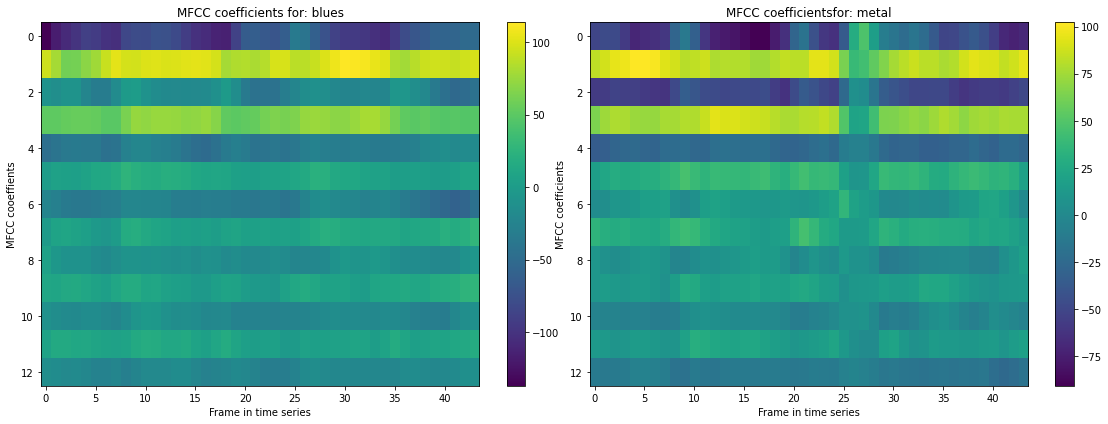

<Figure size 432x288 with 0 Axes>

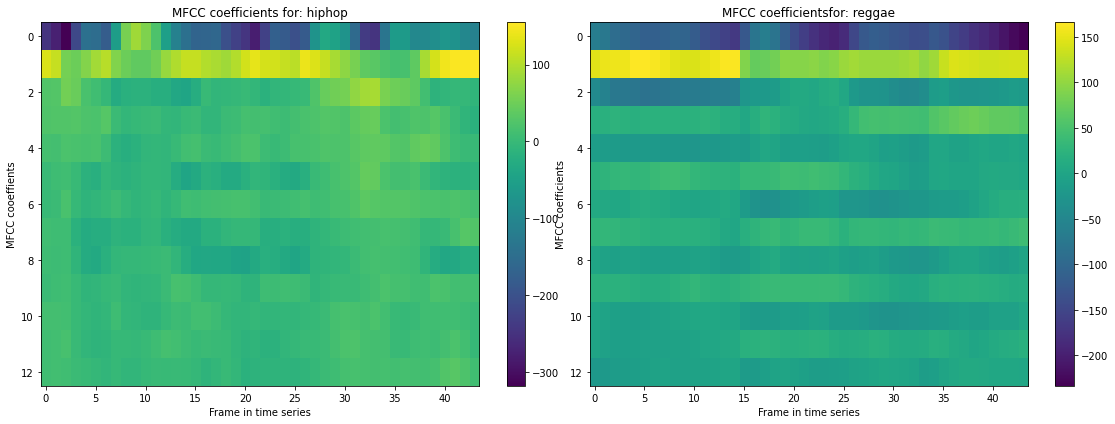

<Figure size 432x288 with 0 Axes>

In [23]:
plot_mfcc_genre_compare('blues','metal')
plot_mfcc_genre_compare('hiphop','reggae')

Also check the distribution of chroma **on time axis** in  each genre

### **Chroma_stft** (updated)

In [24]:
# new plot
# get chroma in time series
show_chroma_dict = {'blues':[],'metal':[],'hiphop':[],'reggae':[]}
for each in genre_analysis_list:
    show_chroma_dict[each] = pd.DataFrame(np.zeros((12,108)))
for each, each_class in zip(genre_data['Path'],tqdm(genre_data['Genre'])):
    hop_length = 1024
    y, sr = librosa.load(each, offset=0, duration=5)
    each_sample = librosa.feature.chroma_stft(y=y, sr=sr,hop_length= hop_length)
    # change 4/24
    show_chroma_dict[each_class] += each_sample
for each in genre_analysis_list:
    show_chroma_dict[each] /= 100.00

In [25]:
show_chroma_dict

{'blues':          0         1         2    ...       105       106       107
 0   0.371506  0.367299  0.356962  ...  0.312887  0.280662  0.299450
 1   0.356839  0.348583  0.338328  ...  0.295931  0.290436  0.285675
 2   0.361248  0.353822  0.308794  ...  0.281588  0.325756  0.322046
 3   0.377833  0.304207  0.271913  ...  0.277642  0.304493  0.294053
 4   0.403950  0.333285  0.333238  ...  0.329485  0.370983  0.359286
 5   0.393489  0.374635  0.368296  ...  0.354875  0.365418  0.355903
 6   0.320618  0.323134  0.294987  ...  0.280005  0.296363  0.297931
 7   0.351919  0.332332  0.306453  ...  0.276867  0.319871  0.325418
 8   0.322796  0.279952  0.289132  ...  0.255199  0.294669  0.314025
 9   0.380551  0.335520  0.314634  ...  0.320189  0.350425  0.391934
 10  0.447128  0.367975  0.331460  ...  0.335378  0.346622  0.369194
 11  0.419405  0.338581  0.330038  ...  0.284425  0.296787  0.348662
 
 [12 rows x 108 columns],
 'hiphop':          0         1         2    ...       105       1

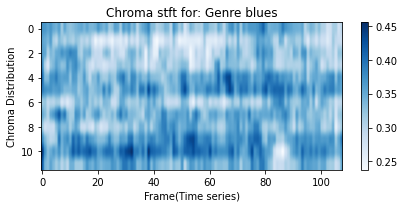

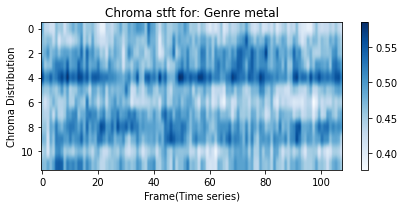

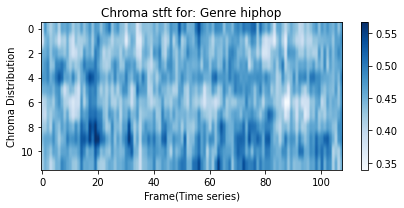

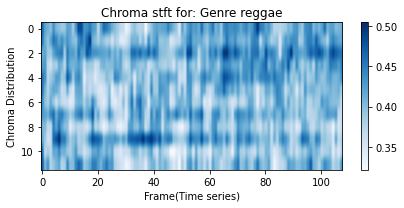

In [26]:
# new plot
for each in genre_analysis_list:
    figure = plt.figure(figsize=(6, 3))
    plt.imshow(show_chroma_dict[each],cmap='Blues', aspect='auto' )
    plt.xlabel('Frame(Time series)')
    plt.ylabel('Chroma Distribution')
    plt.title('Chroma stft for: Genre {}'.format(each))
    plt.colorbar()
    plt.tight_layout()

### Spectral Flatness

get time series of spectral flatness

In [27]:
sample = np.zeros((400,216))
for each,i in zip(genre_data['Path'],tqdm(range(0,400))):
    # read each file
    y, sr = librosa.load(each, offset=0, duration=5)
    each_sample = librosa.feature.spectral_flatness(y=y)[0] 
    # first line: flat
    sample[i] = each_sample
pd_flat = pd.DataFrame(sample)
pd_flat['Genre'] = genre_data['Genre']
show_flat = pd_flat.groupby(['Genre']).mean()
# show data frame
show_flat

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215
Genre,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
blues,0.005861,0.007009,0.002559,0.002272,0.002763,0.002980,0.002946,0.003073,0.003155,0.003164,0.003350,0.003586,0.003540,0.003317,0.003422,0.003816,0.002973,0.003121,0.003734,0.004268,0.003999,0.004368,0.005189,0.004626,0.004213,0.003375,0.003069,0.003515,0.003583,0.003544,0.003372,0.003750,0.004443,0.003869,0.003427,0.003296,0.003250,0.003201,0.003598,0.003874,...,0.003129,0.003445,0.003961,0.003816,0.003684,0.003760,0.003664,0.003056,0.002762,0.003249,0.003983,0.004490,0.003800,0.003285,0.003182,0.003065,0.002982,0.003117,0.003143,0.003038,0.003121,0.003875,0.003482,0.003406,0.003600,0.003786,0.003946,0.003907,0.003674,0.003634,0.003607,0.003863,0.003829,0.003356,0.002859,0.002448,0.002314,0.002704,0.004677,0.005888
hiphop,0.117201,0.120168,0.069183,0.038065,0.035945,0.029767,0.029598,0.034797,0.040853,0.045784,0.049302,0.047756,0.042556,0.044221,0.045426,0.043709,0.043664,0.044287,0.044255,0.043918,0.035335,0.037618,0.036396,0.032231,0.029268,0.031739,0.037515,0.044859,0.048819,0.053382,0.055816,0.049556,0.047654,0.048040,0.048482,0.048739,0.047684,0.046614,0.044835,0.045542,...,0.026289,0.030294,0.035505,0.037066,0.033822,0.031885,0.029592,0.028207,0.031740,0.032298,0.031764,0.031765,0.031290,0.025581,0.022650,0.029745,0.029879,0.029780,0.030299,0.030693,0.029638,0.027102,0.029555,0.034631,0.035832,0.032621,0.030896,0.028711,0.028512,0.022941,0.019098,0.020828,0.022326,0.023844,0.028291,0.034899,0.039081,0.039879,0.039261,0.036309
metal,0.019628,0.028162,0.018124,0.017505,0.017826,0.019309,0.018591,0.017554,0.017123,0.017377,0.018126,0.018138,0.016521,0.016856,0.019471,0.018924,0.018657,0.018658,0.017787,0.017310,0.017420,0.016001,0.014741,0.015159,0.015379,0.015606,0.017149,0.016930,0.018522,0.017894,0.018135,0.016827,0.018032,0.018938,0.019401,0.018490,0.017028,0.016254,0.016780,0.018452,...,0.015563,0.016222,0.016780,0.019870,0.021468,0.022320,0.019676,0.015887,0.014144,0.013170,0.013340,0.013575,0.013867,0.013914,0.014070,0.013776,0.014464,0.014803,0.015209,0.015033,0.015008,0.018282,0.021714,0.021366,0.017254,0.015596,0.015771,0.017297,0.019104,0.016472,0.014386,0.015406,0.016445,0.018099,0.018433,0.017757,0.016253,0.014507,0.022024,0.025279
reggae,0.011975,0.019704,0.016165,0.016494,0.015377,0.013849,0.013418,0.017718,0.018320,0.021303,0.025650,0.026756,0.028626,0.026918,0.024275,0.022605,0.022704,0.018960,0.018169,0.016867,0.013577,0.014703,0.020090,0.020725,0.025462,0.024599,0.022647,0.021059,0.019954,0.021522,0.019660,0.018624,0.016743,0.016725,0.021075,0.021618,0.022798,0.019860,0.019397,0.018830,...,0.018032,0.020278,0.022948,0.021153,0.024034,0.024389,0.024232,0.025955,0.026487,0.027078,0.029061,0.030325,0.023086,0.018083,0.016925,0.017552,0.021330,0.021080,0.019372,0.020858,0.020256,0.020744,0.022557,0.018499,0.017492,0.013418,0.013328,0.017969,0.023448,0.023643,0.023549,0.021163,0.017722,0.018038,0.018892,0.019739,0.019407,0.019506,0.018257,0.014916


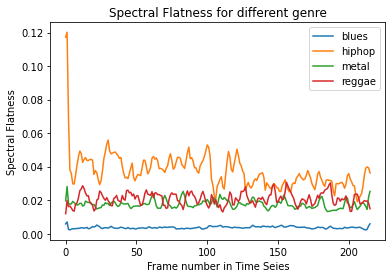

In [28]:
for each in show_flat.index:
    plt.plot(show_flat.loc[each,:])
plt.xlabel('Frame number in Time Seies')
plt.ylabel('Spectral Flatness')
plt.title('Spectral Flatness for different genre')
plt.legend(show_flat.index)

### Tempo

define all sample

In [0]:
def get_tempo_list(audio_path_list,genre_list):
    '''
    function to get mean tempo for passed list
    return pd dataframe
    '''
    for each,i in zip(tqdm(audio_path_list),range(400)):
        y, sr = librosa.load(str(each))
        onset_env = librosa.onset.onset_strength(y, sr=sr)
        features_tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)
        x[i] = round(features_tempo[0])
    data = list(zip(list(genre_list),x))
    pd_tempo = pd.DataFrame(data, columns= ['Genre','Tempo'])
    return pd_tempo

**check all sample tempo**

In [0]:
all_tempo = get_tempo_list(genre_data['Path'].values.tolist(),genre_data['Genre'].values.tolist())
# group by each genre
group_tempo = all_tempo.groupby(['Genre']).mean()


NameError: ignored

In [0]:
group_tempo.T


NameError: ignored

In [0]:
all_tempo.describe().T

,count,mean,std,min,25%,50%,75%,max
Tempo,400.0,122.5625,23.830144,83.0,99.0,123.0,144.0,185.0


### Pulse

In [0]:
def mean_plp(audio_path):
    x , sr = librosa.load(audio_path)
    onset_env = librosa.onset.onset_strength(x, sr=sr)
    pulse = librosa.beat.plp(onset_envelope=onset_env, sr=sr)
    # ???
    # https://librosa.github.io/librosa/generated/librosa.beat.plp.html#librosa.beat.plp
    return np.mean(pulse)

**get list of mean_plp for all**

In [0]:
for each_path,i in zip(genre_data['Path'],range(0,400)):
    pulse[i] = mean_plp(each_path)
pd_pulse = pd.DataFrame(pulse)

pd_pulse


## Feature Extraction 2: MFCC + chroma_stft + centroid + zcr + tempo + rms + spectral flatness



We decided to use the features of MFCC, Chroma_stft, tempogram and zero crossing rate.

1. why we choose these fetures
2. explain the meaning of each features

In [29]:
# test tempogram
# This is just a test to get tempogram features
hop_length = 512
y, sr = librosa.load(genre_data['Path'][1])
oenv = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)
features_tempogram = librosa.feature.tempogram(onset_envelope=oenv, sr=sr,hop_length=hop_length)
# show 
avg = np.mean(features_tempogram,axis=1)
print(np.mean(avg,axis= 0))


0.18802592051835867


In [0]:
# This is a test to add zero crossing rate
y, sr = librosa.load(genre_data['Path'][1])
feature_zcr = librosa.feature.zero_crossing_rate(y,frame_length = 2048, hop_length=512)
# mean + std
print(np.mean(feature_zcr),np.std(feature_zcr))

0.048048310010634185 0.016315251808262494


In [0]:
# test rms
y, sr = librosa.load(genre_data['Path'][1])
features_rms = librosa.feature.rms(y=y)
print(np.mean(features_rms),np.std(features_rms))

0.14835843 0.02661097


Now we can **extract all the features we need**.

Save it both in pandas structure and .csv file.

In [30]:
# get and save all feature values in features.csv
mfcc_list = []
mfcc_value = np.zeros((400, 13))
chroma_value = np.zeros((400, 12))
cent_value = np.zeros((400, 2))
zcr_value = np.zeros((400,2))
stmp_value = np.zeros((400,1))
rms_value = np.zeros((400,2))
flat_value = np.zeros((400,2))

columns =[]
for each_file, index in zip(genre_data['Path'],tqdm(range(0,400))):
    hop_length = 1024 # 512 # 2058
    y, sr = librosa.load(each_file)
    #print("Now processing:",each_file)
    # get feature mfcc
    features_mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13) 
    mfcc_value[index,:] = np.mean(features_mfcc,axis=1)
    # get feature chroma
    features_chroma = librosa.feature.chroma_stft(y,sr)
    chroma_value[index, :] = np.mean(features_chroma, axis=1)
    #---------get feature tempo
    #oenv = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)
    #features_tempo = librosa.feature.tempogram(onset_envelope=oenv, sr=sr,hop_length=hop_length)
    #---------tempo_value[index,:] =  (np.mean(np.mean(features_tempo, axis =1),axis =0),np.std(np.mean(features_tempo, axis =1),axis =0))
    
    # spectral_centroid
    features_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    cent_value[index,:] =(np.mean(features_cent),np.std(features_cent))
    
    #get zero crossing rate
    features_zcr = librosa.feature.zero_crossing_rate(y,frame_length=2048,hop_length=512)
    zcr_value[index,:] =(np.mean(features_zcr),np.std(features_zcr))

    # static_tempo
    onset_env = librosa.onset.onset_strength(y, sr=sr)
    features_tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)
    stmp_value[index,:] = round(features_tempo[0])

    # rms
    features_rms = librosa.feature.rms(y=y)
    rms_value[index,:] = (np.mean(features_rms),np.std(features_rms))

    # spectral flaness
    features_flat = librosa.feature.spectral_flatness(y)
    flat_value[index,:] =(np.mean(features_flat),np.std(features_flat))



# feature_table is the df of mfcc_value
features_value = pd.DataFrame(mfcc_value)
# add other feature, chroma also inside this table

# update features_value and save to .csv
features_value = pd.concat([features_value, pd.DataFrame(chroma_value)], axis=1)
features_value = pd.concat([features_value, pd.DataFrame(cent_value)], axis=1)
features_value = pd.concat([features_value, pd.DataFrame(zcr_value)], axis=1)
features_value = pd.concat([features_value, pd.DataFrame(stmp_value)], axis=1)
features_value = pd.concat([features_value, pd.DataFrame(rms_value)], axis=1)
features_value = pd.concat([features_value, pd.DataFrame(flat_value)], axis=1)

# update the features_value dataframe column name to mfcc1 to mfcc13, chroma 1 to 12
col_name = []
for index in range(0,13):
    col_name.append('mfcc'+str(index+1))
for index in range(0,12):
    col_name.append('chroma'+str(index+1))
for index in range(0,2):
    col_name.append('cent'+str(index+1))
for index in range(0,2):
    col_name.append('zcr'+str(index+1))
for index in range(0,1):
    col_name.append('tempo'+str(index+1))
for index in range(0,2):
    col_name.append('rms'+str(index+1))
for index in range(0,2):
    col_name.append('flat'+str(index+1))

features_value.columns = col_name
# save to .csv
features_value.to_csv('./features.csv',sep = '\t', index = False)
print("Finished processing, saved all features.")
# need to wait some time to see the result.



Finished processing, saved all features.


In [31]:
features_value

,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,chroma1,chroma2,chroma3,chroma4,chroma5,chroma6,chroma7,chroma8,chroma9,chroma10,chroma11,chroma12,cent1,cent2,zcr1,zcr2,tempo1,rms1,rms2,flat1,flat2
0,-209.826150,124.463215,10.342456,47.010909,6.508127,15.410516,-2.005106,6.706564,-21.557632,10.718406,-5.523687,-2.199806,-3.034864,0.127189,0.141863,0.170973,0.146901,0.189883,0.232139,0.156369,0.216600,0.345021,0.384547,0.691413,0.373657,1324.293218,414.095391,0.051402,0.035431,108.0,0.113170,0.064722,0.001191,0.001261
1,-107.170265,88.488187,-4.169413,55.477715,-8.013872,38.415162,-6.410026,28.572667,-19.821608,13.238089,-19.253099,12.072362,-4.578394,0.324107,0.358768,0.419697,0.567364,0.303946,0.251674,0.324632,0.393840,0.453285,0.426857,0.491156,0.327088,2390.390100,553.734076,0.102261,0.039947,129.0,0.129166,0.029503,0.007607,0.006534
2,-89.354890,93.800390,-14.560049,54.388645,-33.502993,19.423905,-19.761012,13.031584,-13.861511,14.615304,-14.968037,10.597504,-18.022168,0.483075,0.242483,0.250919,0.235217,0.315011,0.613605,0.256483,0.262924,0.242337,0.346093,0.191305,0.222650,2428.928767,312.600973,0.134641,0.037805,144.0,0.120560,0.018036,0.008374,0.006086
3,-238.951198,108.705427,34.145849,30.211149,-0.502583,27.292958,-21.399484,14.171864,-24.512312,-1.884265,-28.057500,-11.255747,-16.464363,0.312232,0.216736,0.176883,0.155128,0.243879,0.456762,0.316402,0.235207,0.210369,0.269277,0.281575,0.253173,1430.492433,837.162935,0.041974,0.037936,152.0,0.133214,0.047458,0.000805,0.002144
4,-346.969336,139.273043,24.147860,22.209932,18.703974,11.669042,9.033813,6.945858,-2.019918,5.418928,1.674157,-2.352553,3.198617,0.390058,0.281551,0.221052,0.222528,0.248625,0.253850,0.270304,0.389678,0.448867,0.535472,0.468288,0.451422,798.451172,445.463115,0.025648,0.020114,108.0,0.052853,0.042476,0.000764,0.006836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,-103.136673,67.205032,2.212647,28.504494,4.172197,11.874952,14.244765,14.292828,3.261752,15.854268,8.042967,4.469097,8.679431,0.527038,0.473009,0.393383,0.333580,0.327089,0.369955,0.427632,0.414551,0.516528,0.569701,0.674864,0.695776,2539.121009,936.008816,0.094298,0.070644,99.0,0.195715,0.102957,0.043690,0.072337
396,-132.977565,117.143566,-2.825532,22.537389,25.921838,0.278448,13.535487,3.408554,4.533075,0.545919,-0.066564,5.103181,-0.161246,0.337143,0.344633,0.465506,0.385335,0.419384,0.412514,0.390618,0.431549,0.443899,0.496101,0.317166,0.309023,1728.254305,521.916601,0.060468,0.032532,161.0,0.140145,0.044343,0.009812,0.014022
397,-164.594570,142.707450,-41.489226,41.226193,16.171186,-5.588592,7.633069,5.620200,0.810726,-10.478095,-2.344436,-0.496347,-3.065764,0.616168,0.247922,0.224886,0.266965,0.492462,0.430814,0.326586,0.485215,0.227387,0.222506,0.141551,0.334345,1484.715976,338.400244,0.076013,0.033668,152.0,0.110707,0.042192,0.003385,0.003977
398,-169.175089,110.450371,-8.545039,43.888601,0.316973,26.636772,-14.361243,13.035166,-11.153996,8.111966,-7.677317,10.930494,-8.167287,0.411790,0.332711,0.389301,0.370354,0.308819,0.386656,0.288723,0.330068,0.243243,0.297590,0.423093,0.402035,1811.234934,809.902274,0.072150,0.051697,136.0,0.123739,0.053039,0.004307,0.008161


## Feature Rescaling

In [0]:
#import sklearn.preprocessing as preprocessing
features_rescaled = pd.DataFrame(preprocessing.scale(features_value), columns=features_value.columns, index=features_value.index)
features_rescaled.to_csv('./re_features.csv',sep = '\t', index = False)

In [53]:
features_rescaled.describe()

,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,chroma1,chroma2,chroma3,chroma4,chroma5,chroma6,chroma7,chroma8,chroma9,chroma10,chroma11,chroma12,cent1,cent2,zcr1,zcr2,tempo1,rms1,rms2,flat1,flat2
count,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02
mean,2.163547e-16,1.034728e-15,-4.440892e-17,7.049916e-17,8.743006e-17,-2.664535e-17,-3.663736e-16,3.348710e-16,9.908740e-17,-1.962319e-16,3.341771e-16,2.209344e-16,1.809664e-16,-4.835195e-16,-2.332856e-16,-1.465494e-16,-4.504730e-16,-1.337819e-16,-3.629042e-16,-3.694267e-16,2.227385e-17,4.671263e-16,1.941503e-16,3.078787e-16,-4.182418e-17,3.094747e-17,-3.597123e-16,5.220824e-16,-2.405021e-16,8.021361e-17,1.146305e-16,-8.409939e-17,1.066508e-16,-1.963707e-17
std,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00
min,-3.021479e+00,-3.797117e+00,-3.560271e+00,-2.771183e+00,-2.682491e+00,-3.364409e+00,-2.574820e+00,-2.715545e+00,-2.438470e+00,-2.813262e+00,-2.874989e+00,-2.982377e+00,-3.073133e+00,-2.857675e+00,-2.599036e+00,-2.957918e+00,-2.367860e+00,-2.638915e+00,-3.117863e+00,-2.704511e+00,-3.053457e+00,-2.538488e+00,-2.582758e+00,-2.597180e+00,-2.685416e+00,-2.768787e+00,-1.682206e+00,-1.937006e+00,-1.899235e+00,-1.662266e+00,-2.016481e+00,-1.605535e+00,-6.656150e-01,-7.980346e-01
25%,-6.864699e-01,-6.554488e-01,-7.286502e-01,-7.246703e-01,-7.034648e-01,-6.857107e-01,-7.394485e-01,-7.445617e-01,-7.542615e-01,-8.046345e-01,-7.260222e-01,-6.862412e-01,-7.149468e-01,-6.481857e-01,-6.048665e-01,-6.036656e-01,-6.621476e-01,-7.066316e-01,-6.593021e-01,-6.527770e-01,-5.835041e-01,-7.357565e-01,-6.987357e-01,-6.641790e-01,-6.350650e-01,-7.343236e-01,-7.845489e-01,-7.791097e-01,-6.844083e-01,-9.900069e-01,-7.695575e-01,-6.632327e-01,-5.098907e-01,-5.964683e-01
50%,1.696501e-01,6.043220e-03,-5.928621e-02,4.604820e-02,9.816163e-02,1.672599e-01,-1.276976e-01,1.494434e-01,-1.615289e-01,1.545667e-01,-5.574161e-02,8.173526e-02,-9.738192e-03,2.504438e-02,-1.111577e-02,-2.943889e-03,4.194957e-02,-4.583892e-02,3.758396e-04,-1.745682e-02,2.383689e-02,4.360864e-02,-2.988635e-02,-9.974408e-03,-4.612995e-02,7.582951e-02,-2.635457e-01,-9.344256e-02,-2.219361e-01,1.838209e-02,-2.321299e-01,-2.307338e-01,-2.832415e-01,-3.969840e-01
75%,6.448121e-01,6.327305e-01,6.674040e-01,7.010302e-01,6.937359e-01,7.083727e-01,8.289737e-01,7.519821e-01,8.143617e-01,8.172617e-01,6.975311e-01,7.661312e-01,7.909608e-01,6.265854e-01,6.265700e-01,6.093171e-01,6.472386e-01,6.954438e-01,6.687853e-01,6.061960e-01,6.655350e-01,6.408436e-01,6.719140e-01,6.499924e-01,6.371547e-01,6.850945e-01,6.455860e-01,6.595280e-01,4.212409e-01,9.007225e-01,7.037100e-01,3.825213e-01,1.738726e-01,3.312616e-01
max,2.199507e+00,3.069193e+00,2.890171e+00,2.304428e+00,2.509991e+00,2.375337e+00,2.308378e+00,2.466289e+00,2.105561e+00,2.215130e+00,3.125507e+00,2.322753e+00,2.334336e+00,2.788885e+00,3.436844e+00,2.696761e+00,3.428770e+00,3.154630e+00,2.841294e+00,3.428881e+00,2.312064e+00,3.056003e+00,2.869476e+00,3.173975e+00,3.349387e+00,3.564519e+00,4.006308e+00,3.840810e+00,5.375217e+00,2.623387e+00,3.369157e+00,4.016856e+00,1.377135e+01,8.476856e+00


 ## Visualize the feature

Check all feature values

In [0]:
features_value.describe()

,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,chroma1,chroma2,chroma3,chroma4,chroma5,chroma6,chroma7,chroma8,chroma9,chroma10,chroma11,chroma12,cent1,cent2,zcr1,zcr2,tempo1,rms1,rms2,flat1,flat2
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,-123.302809,93.103490,-10.708109,44.586473,-2.647285,20.647792,-6.601616,15.119746,-7.784932,10.608834,-6.267335,7.243566,-5.888498,0.418017,0.404597,0.423493,0.415418,0.435819,0.417033,0.399524,0.421189,0.422162,0.441138,0.427015,0.424282,2259.825286,662.643585,0.106493,0.052253,122.562500,0.147598,0.053840,0.019570,0.023964
std,75.266544,24.935616,22.262692,15.691987,13.527896,10.337941,10.238306,9.188245,7.979676,7.504931,7.588709,6.807039,7.048743,0.104106,0.117047,0.113602,0.113543,0.118321,0.100998,0.104287,0.111097,0.116205,0.116427,0.110050,0.111363,611.062168,269.915092,0.043832,0.021833,23.830144,0.060464,0.028050,0.028954,0.029677
min,-350.434656,-1.461542,-89.870197,1.155494,-38.890351,-14.089770,-32.930434,-9.800140,-27.218797,-10.478095,-28.057500,-13.032196,-27.523131,0.120889,0.100767,0.087887,0.146901,0.123971,0.102530,0.117831,0.082383,0.127545,0.140811,0.141551,0.125599,570.040355,209.158637,0.021697,0.010838,83.000000,0.025826,0.008861,0.000322,0.000310
25%,-174.906400,76.779914,-26.909533,33.229180,-12.151781,13.567823,-14.162847,8.287087,-13.796166,4.577661,-11.770015,2.578138,-10.921671,0.350622,0.333888,0.355001,0.340330,0.352315,0.350528,0.331533,0.356445,0.336770,0.359888,0.354013,0.353648,1811.669152,451.146869,0.072386,0.037329,99.000000,0.101126,0.035260,0.004826,0.006284
50%,-110.549807,93.253993,-12.026329,45.308157,-1.321026,22.374753,-7.907388,16.491150,-9.072268,11.767396,-6.689813,7.799245,-5.957054,0.420621,0.403298,0.423159,0.420175,0.430402,0.417071,0.397705,0.423834,0.427223,0.437663,0.425918,0.419151,2306.103872,591.597601,0.102402,0.047413,123.000000,0.133580,0.047376,0.011380,0.012197
75%,-74.830733,108.861281,4.131517,55.573270,6.725764,27.961748,1.875055,22.020500,-1.294718,16.734655,-0.980595,12.452128,-0.320192,0.483167,0.477844,0.492626,0.488816,0.518002,0.484495,0.462663,0.495036,0.496538,0.519270,0.498457,0.495149,2677.937021,836.679042,0.135365,0.061439,144.000000,0.190093,0.064556,0.024598,0.033782
max,42.039432,169.539988,53.554402,80.702302,31.265146,45.173174,17.002701,37.752269,8.995744,27.212436,17.421561,23.034858,10.545053,0.707993,0.806368,0.729468,0.804244,0.808611,0.703639,0.756665,0.677732,0.776841,0.774805,0.775875,0.796815,4435.243901,1742.654028,0.274631,0.169465,185.000000,0.351055,0.166372,0.417805,0.275216


Check **zero crossing rate**

this feature might indicates the presence of how much different instruments are used

No handles with labels found to put in legend.


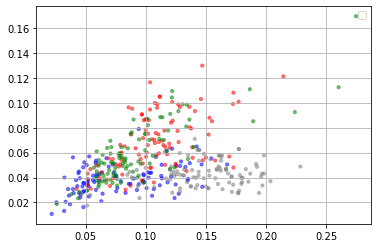

In [0]:
x = features_value['zcr1']
y = features_value['zcr2']
# set colors
color_to_genre = {'blues':'blue','metal':'grey','hiphop':'red','reggae':'green'}
colors = []
for each in genre_data['Genre']:
    colors.append(color_to_genre[each])

area = 10
plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.grid(True)
plt.legend()
plt.show()

Check **centroid**

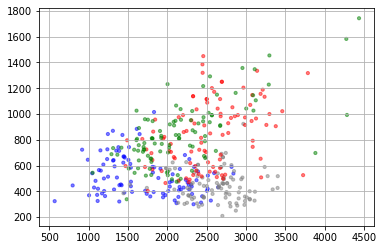

In [0]:
x = features_value['cent1']
y = features_value['cent2']
# set colors
colors = []
for each in genre_data['Genre']:
    colors.append(color_to_genre[each])

area = 10
plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.grid(True)
plt.show()

**Check rms**

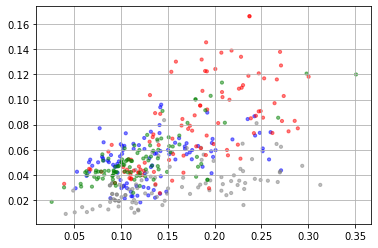

In [0]:
x = features_value['rms1']
y = features_value['rms2']
# set colors
colors = []
for each in genre_data['Genre']:
    colors.append(color_to_genre[each])

area = 10
plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.grid(True)
plt.show()

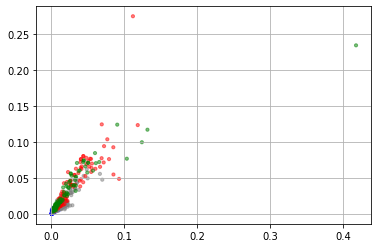

In [0]:
x = features_value['flat1']
y = features_value['flat2']
# set colors
colors = []
for each in genre_data['Genre']:
    colors.append(color_to_genre[each])

area = 10
plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.grid(True)
plt.show()

There are extra value in the flatness.

In [0]:
# the strange sample 4/23 didn't finish
x1 = np.max(features_value['flat1'])
print("x1=",x1)
features_value.loc[x1,:]
genre_data.tail(1)

# another strange sample
x2 = np.max(features_value['flat2'])
print("x2=",x2)
features_value.loc[x2,:]


## Feature Selection

Since we have a multi dimensional feature list, 

although they all seems useful. But some of it might not have be helpful enough to support our classification model.
So we can use  **sklearn.feature_selection module** to check some useless feature.

[Ref](https://scikit-learn.org/stable/modules/feature_selection.html)

In [0]:
from sklearn.feature_selection import VarianceThreshold
# Remove features with low variance
X_t1 = features_rescaled

sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
X_del_useless_feature = sel.fit_transform(X_t1)

In [63]:
print(X_del_useless_feature)

[[-1.15099875  1.25920282  0.94673759 ...  0.38843355 -0.6355828
  -0.76595601]
 [ 0.21460727 -0.18532059  0.29407425 ... -0.86872285 -0.41369219
  -0.58805898]
 [ 0.45160083  0.02798297 -0.1732389  ... -1.27802266 -0.38718501
  -0.60316014]
 ...
 [-0.54929415  1.99177282 -1.38436381 ... -0.41578915 -0.55969871
  -0.67431593]
 [-0.61022767  0.69653805  0.09728289 ... -0.02858516 -0.52783078
  -0.53314227]
 [-0.19713662  0.33643326 -1.10797571 ... -0.44319875 -0.15333553
  -0.17237   ]]



## Data Spliting

What's the benefit about data spliting,

1. By dividing the data set according to a certain ratio, we can reasonably evaluate the performance of the learning algorithm in the face of unknown data.

2. If the data used to evaluate the model is not independent of the sample, the evaluation result may be inaccurate. We also want this model can be applied in a wider range of situations.



The simple way to do the data spliting is to use *sklearn.model_selection.train_test_split* to split to **Training set** and **Testing set**.


In [90]:
# sklearn provides the function to split data
# from sklearn.model_selection import train_test_split
# get the features
features = X_del_useless_feature# features = features_value
# I am changing feature selection
# get only the labeled genre result
result = genre_data['Genre']

# Use sklearn.train_test_split to split 80 % for training and 20% for testing
# the random seed is set to 22 here in order to see a fixed output based on this.
for each in tqdm(genre_analysis_list):
    X_train, X_test,y_train,y_test = train_test_split(
        features, result,
        test_size = 0.2,
        random_state = 42, shuffle = True) #22

Seconderly, another way to do the spliting, is to use **K-fold cross validating** method.

The advantage of applying this method:

1. we only have 400 audio piece in total, it's realatively a small amout of sample
2. to make the future model more accurate


**K-fold cross-validation** to do the selecting for the best parameter for the future model in order to increase the accuary dealing with unseen data.


The workflow in this part should be like this,
<div>
<img src="https://scikit-learn.org/stable/_images/grid_search_workflow.png" width="500"/>
</div>

The general procedure for Cross-Validating is:

1. Shuffle the dataset randomly.
2. Split the dataset into k groups
3. For each unique group:
    - Take the group as a hold out or test data set
    - Take the remaining groups as a training data set
    - Fit a model on the training set and evaluate it on the test set
    - Retain the evaluation score and discard the model
    - Summarize the skill of the model using the sample of model evaluation scores

**Reference**
1. [Wiki](https://en.wikipedia.org/wiki/Cross-validation_(statistics))
2. [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html)

## Observing the Training Set

We can visusalise the feature we want to use from the splited subset **X_train** and its genre label **y_train** .



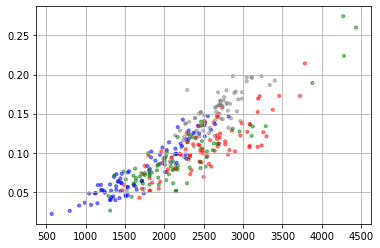

In [0]:
# test plot 1 using
x = X_train['cent1']
y = X_train['zcr1']
color_to_genre = {'blues':'blue','metal':'grey','hiphop':'red','reggae':'green'}

colors = []
for each in y_train:
    colors.append(color_to_genre[each])

area = 10
plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.grid(True)
plt.show()

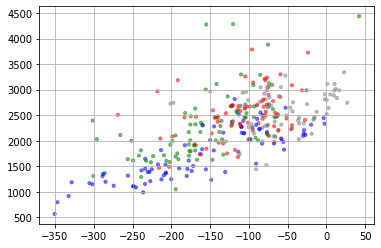

In [0]:
# test plot 2 using
x = X_train['mfcc1']
y = X_train['cent1']
color_to_genre = {'blues':'blue','metal':'grey','hiphop':'red','reggae':'green'}

colors = []
for each in y_train:
    colors.append(color_to_genre[each])

area = 10
plt.scatter(x, y, s=area, c=colors, alpha=0.5)

plt.grid(True)
plt.show()

3d

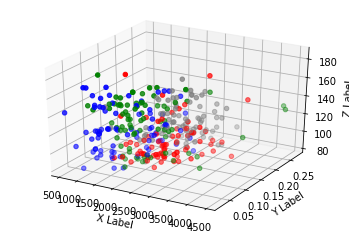

In [0]:
fig = plt.figure()
#plt.rcParams['figure.figsize'] = (20.0, 10.0)

ax = fig.add_subplot(111, projection='3d')

m = 'o'
xs = X_train['cent1']
ys = X_train['zcr1']
zs = X_train['tempo1']
ax.scatter(xs, ys, zs, marker=m,color = colors)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')


plt.show()


## Modelling Classifier(1): KNN

As for classifier, we can try different approaches, 

1. use **K Neighbour Classfier**
2. use **Support Vector Classifier** or others.

We can test each model with the already splited dataset and try to find the best parameters to see the best result they could have.

The parameters for KNN Classifier are **searching algorithm**, **n_neighbors**, **weights** and **p** (the way to calculate distance)

Here is a simple test example using the dataset we have.


Here is a **Simple test... with random parameters**

In [91]:
kClassifier = neighbors.KNeighborsClassifier(n_neighbors=15,weights = 'distance')
kClassifier.fit(X_train,y_train)

predictedTestLabels = kClassifier.predict(X_test)
  
print(kClassifier.score(X_test,y_test))

0.75


Now we can try to find a better k and weight to get higher score.


For the **algorithm**, we can just choose **'auto'**, since this method would choose the fatest method from the other three, 'brute', 'kd_tree', 'ball_tree'.

But for k and p, we will just enumerate all the combinations of different parameter set to check which has the highest score. 

(Is this called Grid Search to get the best parameter set?)

### Cross Validation: KNN 
We have training set (320 audio) and testing set(80 audio).

We can use the training set also for cross validation, and save the testing set to evaluate the model for final conclusion.

Using cross validation, we can improve the model,
by searching for a better **k** with **p**



In [92]:
# Test cross validation, k-fold
# is this right? or something wrong?
%%time
best_p = -1
best_score = 0.0
best_k = -1
for k in range(1, 11):
    for p in range(1, 6):
        knn_clf = neighbors.KNeighborsClassifier(n_neighbors = k, weights = "distance", p = p)
        knn_clf.fit(X_train, y_train)
        knn_score = np.mean(cross_val_score(knn_clf, X_train, y_train, cv=10, scoring='accuracy'))
        #print("New cross test",cross_val_score(knn_clf, X_train, y_train, cv=10, scoring='accuracy'))
        if knn_score > best_score:
            best_score = knn_score
            best_k = k
            best_p = p

print("best_p = ", best_p, ", the best_k = ", best_k,", and best_score = ", best_score)



best_p =  2 , the best_k =  5 , and best_score =  0.840625
CPU times: user 8.48 s, sys: 635 µs, total: 8.48 s
Wall time: 8.48 s


### Evaluation: KNN



Check the result

### Testing: KNN
So we can use the best parameter for training

In [93]:
kClassifier = neighbors.KNeighborsClassifier(n_neighbors=5, weights = 'distance',p =2)
kClassifier.fit(X_train,y_train)

predictedTestLabels = kClassifier.predict(X_test)
  
print(kClassifier.score(X_test,y_test))

0.775


**Confusion Matrix**

So up to now, the best parameter for current KNN model should use **k = ?, p =? **.

(With different testing data, different result of parameters)

We can get the percentage of the accuracy for the prediction result,then together with the genre label of the testdata we can plot the **Confusion Matrix** as followed.

Each **row** in the matrix is the real genre, while each **column** is the predicted genre category classified by the model we build.

From the result of this Confusion Matrix, we can clearly see that the only music genre that has been difficult for our KNN model to classify is the "Regea". The result shows that the accuracy rate is only 0.48. And 0.43 has been put in the wrong genre a "metal".


[[0.84615385 0.         0.         0.15384615]
 [0.         0.83333333 0.11111111 0.05555556]
 [0.05555556 0.16666667 0.77777778 0.        ]
 [0.05555556 0.33333333 0.         0.61111111]]


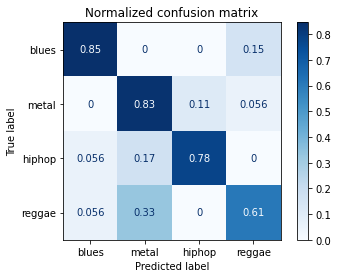

In [94]:
#from sklearn.metrics import plot_confusion_matrix
# plot confusion matrix
title = "Normalized confusion matrix"
disp = plot_confusion_matrix(kClassifier,X_test, y_test,
                                 display_labels=genre_analysis_list, # genre names list
                                 cmap=plt.cm.Blues,
                                 normalize='true')
disp.ax_.set_title(title)

print()
print(disp.confusion_matrix)

plt.show()

## Modelling Classifier(2): SVC

using sklearn [SVM](https://scikit-learn.org/stable/modules/svm.html#classification)

In this part, we can use the simplest svm to get get prediction of the music genre using test data.

In [95]:
from sklearn import svm
from sklearn.model_selection import cross_val_score

X = X_train #feature training data
Y = y_train # genre
clf = svm.SVC(decision_function_shape='ovo')

# the predicted result
clf.fit(X, Y)
#print(clf.predict(X_test))
# check the score of the predicted result
scores = cross_val_score(clf,features,result, cv=5)
np.mean(scores)


0.8150000000000001

Plot the prediction result and the difference between the test result.


### Cross Validation: SVC

This part **runs really slow**...
- need to check if it is possible to run faster

In [96]:

tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']
print("Still searching....please wait...")
for score in tqdm(scores):
    print("# Tuning hyper-parameters for %s" % score)
    print()
    # use Parallelism
    # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
    clf = GridSearchCV(
        svm.SVC(), tuned_parameters, scoring='%s_macro' % score, n_jobs = -1)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

Still searching....please wait...


# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 1, 'kernel': 'linear'}

Grid scores on development set:

0.724 (+/-0.067) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.183 (+/-0.136) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.798 (+/-0.102) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.723 (+/-0.069) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.798 (+/-0.090) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.792 (+/-0.104) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.797 (+/-0.146) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.804 (+/-0.052) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.805 (+/-0.090) for {'C': 1, 'kernel': 'linear'}
0.791 (+/-0.163) for {'C': 10, 'kernel': 'linear'}
0.792 (+/-0.144) for {'C': 100, 'kernel': 'linear'}
0.782 (+/-0.133) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full eva

### Testing: SVC

Then, we can see the best parameter set
{'C': 10, 'gamma': 0.001, 'kernel': 'linear'}


[[0.76923077 0.03846154 0.         0.19230769]
 [0.05555556 0.83333333 0.05555556 0.05555556]
 [0.05555556 0.05555556 0.88888889 0.        ]
 [0.         0.27777778 0.         0.72222222]]


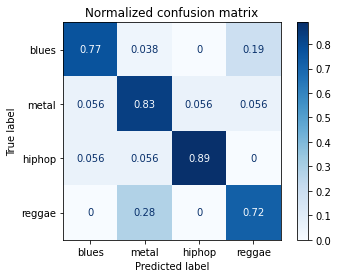

In [97]:
from sklearn.metrics import plot_confusion_matrix
# plot confusion matrix
title = "Normalized confusion matrix"
clf = svm.SVC(C=1000.0,kernel ='rbf',gamma= 0.0001,)
clf.fit(X, Y)
disp = plot_confusion_matrix(clf,X_test, y_test,
                                 display_labels=genre_analysis_list, # genre names list
                                 cmap=plt.cm.Blues,
                                 normalize='true')
disp.ax_.set_title(title)

print()
print(disp.confusion_matrix)

plt.show()

## About Team Work
**0410 Discussion**
1. apply preprocessing to audio files
2. how to split our dataset to {training, testing} to make sure the difference of the two groups
3. check if our dataset is balanced? Actually it is already balanced.
4. which set of features can to useful for our cases
5. apply feature selection?
6. choose which classification method?
7. try different parameter for the classfier
8. evaluate the model
9. display the result
**0411 Discussion**
1. do some test individually, using different classfiers
**0422 Discussion**
1. finish HW1: add tempo features(peakA1,A0,beat...)
2. start to write Document, do it together
3. still need to fix some error
4. complete the model evaluation,optimization
5. then, write the introduction and final conclusion

**0510**
1. document

**0514**
1. group discussion
2. finish final document


## Reference Materials

1. [librosa Library](http://librosa.github.io/librosa/generated/librosa.feature.tempogram.html#librosa.feature.tempogram)
2. [Pandas Library](https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf)
2. [sklearn cheat sheet](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Scikit_Learn_Cheat_Sheet_Python.pdf)
2. [sklearn, machine learning library](https://scikit-learn.org/stable/) 
3. [Essentia Library](https://essentia.upf.edu/essentia_python_tutorial.html) 
4. VAMP plugin python wrapper
5. The GTZAN dataset: Its contents, its faults, their effects on evaluation, and its future us, Bob L. Sturm, [2013](https://arxiv.org/abs/1306.1461)
6. Mattia recommend, [Musical Genre Classification of Audio Signals](https://dspace.library.uvic.ca/bitstream/handle/1828/1344/tsap02gtzan.pdf?sequence=1)
7. Miriam recommend, [Feature Extraction](http://www.ifs.tuwien.ac.at/~schindler/lectures/MIR_Feature_Extraction.html), Alexander Schindler

8. reference for how to present a report [MusicGenreClassification Report cs229](http://cs229.stanford.edu/proj2016/report/BurlinCremeLenain-MusicGenreClassification-report.pdf)